In [62]:
#%load_ext pycodestyle_magic
#%flake8_on

1:1: E265 block comment should start with '# '
2:1: E265 block comment should start with '# '


In [63]:
import os
import sys
import random

import albumentations as A
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET

# Check versions of libraries
print(f"Python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"OpenCV: {cv2.__version__}")

Python: 3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
numpy: 1.20.1
matplotlib: 3.3.4
OpenCV: 4.5.2


In [64]:
CURRENT_DIR = os.getcwd()
TRAINING_SET_DIR = os.path.join(CURRENT_DIR, "images", "training_set")
VALIDATION_SET_DIR = os.path.join(CURRENT_DIR, "images", "validation_set")

IMAGE_WIDTH = 300
IMAGE_HEIGHT = 300

In [65]:
def parse_annotations(xml_file: str):
    """https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python"""
    """Parses the annotation file and returns the bounding boxes and breed names"""

    tree = ET.parse(xml_file)
    root = tree.getroot()

    all_bounding_boxes = []
    all_breed_names = []

    for boxes in root.iter("object"):
        breed_name = root.find("object").find("name").text
        all_breed_names.append(breed_name)

        xmin, xmax, ymin, ymax = None, None, None, None

        # Finds the bounding box coordinates of the dog within the image
        xmin = int(boxes.find("bndbox/xmin").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        ymin = int(boxes.find("bndbox/ymin").text)
        ymax = int(boxes.find("bndbox/ymax").text)

        bounding_box = (xmin, ymin, xmax, ymax)
        all_bounding_boxes.append(bounding_box)

    return all_bounding_boxes, all_breed_names

2:80: E501 line too long (95 > 79 characters)
3:80: E501 line too long (83 > 79 characters)


In [66]:
def load_data(image_set_dir, image_width, image_height):
    """Loads image data and breed names from directory"""

    # Lists for image data and breed names
    image_data = []
    all_bounding_boxes = []
    all_breed_names = []

    # Iterates the files as (with the help of sorted()):
    # breedId1_dogId1
    # breedId1_dogId1.jpg
    # breedId1_dogId2
    # breedId1_dogId2.jpg
    # ...
    # breedId120_dogIdX.jpg
    for breed_folder in os.listdir(image_set_dir):
        for file in sorted(os.listdir(os.path.join(image_set_dir, breed_folder))):
            file_path = os.path.join(image_set_dir, breed_folder, file)

            # Checks images to resize and crop according to its bounding box
            if file_path.endswith(".jpg"):
                image = cv2.imread(file_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Did not resize nor crop images
                # Only add the raw image to the list
                image_data.append(image)

            # Checks annotation files for the dog's breed and its bounding boxes
            else:
                bounding_boxes, breed_names = parse_annotations(file_path)

                # May have multiple dogs and bounding boxes for 1 image
                all_bounding_boxes.append(bounding_boxes)
                all_breed_names.append(breed_names)

    return image_data, all_bounding_boxes, all_breed_names

17:80: E501 line too long (82 > 79 characters)
29:80: E501 line too long (80 > 79 characters)


In [67]:
image_data_train, bounding_boxes_train, breed_names_train\
    = load_data(TRAINING_SET_DIR, IMAGE_WIDTH, IMAGE_HEIGHT)

image_data_validation, bounding_boxes_validation, breed_names_validation\
    = load_data(VALIDATION_SET_DIR, IMAGE_WIDTH, IMAGE_HEIGHT)

print(f"Training images: {len(image_data_train)}")
print(f"Valdiation images: {len(image_data_validation)}")

Training images: 12000
Valdiation images: 8580


In [68]:
def augment_image(image, bounding_boxes, breed_names, image_width, image_height):
    """Augments one image and its bounding boxes


    Following these:
    https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    """

    # Augment the image and its bounding boxes
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(translate_percent=(0, 0.2), rotate=(-30, 30)),
        A.RandomBrightnessContrast(p=0.2),
        A.Blur(),
        A.Resize(width=image_width, height=image_height),
    ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

    # Note: bboxes expect a list of multiple bounding boxes
    # [[xmin, ymin, xmax, ymax], [xmin, ymin, xmax, ymax], ...]
    # class_labels expect a list of strings
    # ["class1", "class2", ...]
    transformed = transform(image=image, bboxes=bounding_boxes, class_labels=breed_names)

    transformed_image = transformed["image"]
    transformed_bounding_boxes = transformed["bboxes"]
    transformed_class_labels = transformed["class_labels"]

    return transformed_image, transformed_bounding_boxes, transformed_class_labels

1:80: E501 line too long (81 > 79 characters)
16:80: E501 line too long (84 > 79 characters)
22:80: E501 line too long (89 > 79 characters)
28:80: E501 line too long (82 > 79 characters)


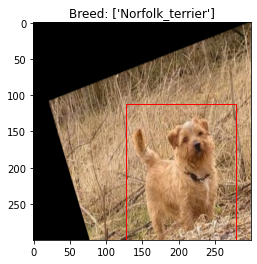

[(126.70672556916328, 111.87409348547776, 279.22196352881946, 300.0)]


3:61: E127 continuation line over-indented for visual indent
3:80: E501 line too long (84 > 79 characters)
4:61: E127 continuation line over-indented for visual indent
4:80: E501 line too long (81 > 79 characters)
5:61: E127 continuation line over-indented for visual indent
6:61: E127 continuation line over-indented for visual indent
12:80: E501 line too long (95 > 79 characters)
13:80: E501 line too long (94 > 79 characters)
14:80: E501 line too long (94 > 79 characters)


In [69]:
"""Testing data augmentation with the first training image"""
test_image, test_bounding_box, test_labels = augment_image(image_data_train[0],
                                                            bounding_boxes_train[0],
                                                            breed_names_train[0],
                                                            IMAGE_WIDTH,
                                                            IMAGE_HEIGHT)

plt.imshow(test_image)
plt.title(f"Breed: {test_labels}")

# Create a visual bounding box
bounding_box = matplotlib.patches.Rectangle((test_bounding_box[0][0], test_bounding_box[0][1]),
                                            test_bounding_box[0][2] - test_bounding_box[0][0],
                                            test_bounding_box[0][3] - test_bounding_box[0][1],
                                            linewidth=1,
                                            edgecolor='r',
                                            facecolor='none')
plt.gca().add_patch(bounding_box)

plt.show()
print(test_bounding_box)

In [70]:
def image_view(images, labels):
    """Displays a 3x3 subplot of randomly selected images"""

    fig, ax = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        for j in range(3):
            # Selects a random image and displays it
            index = random.randint(0, len(images) - 1)
            ax[i, j].imshow(images[index])

            # Displays the breed's name as the title
            ax[i, j].set_title(f"Breed: {labels[index]}")

    plt.show()

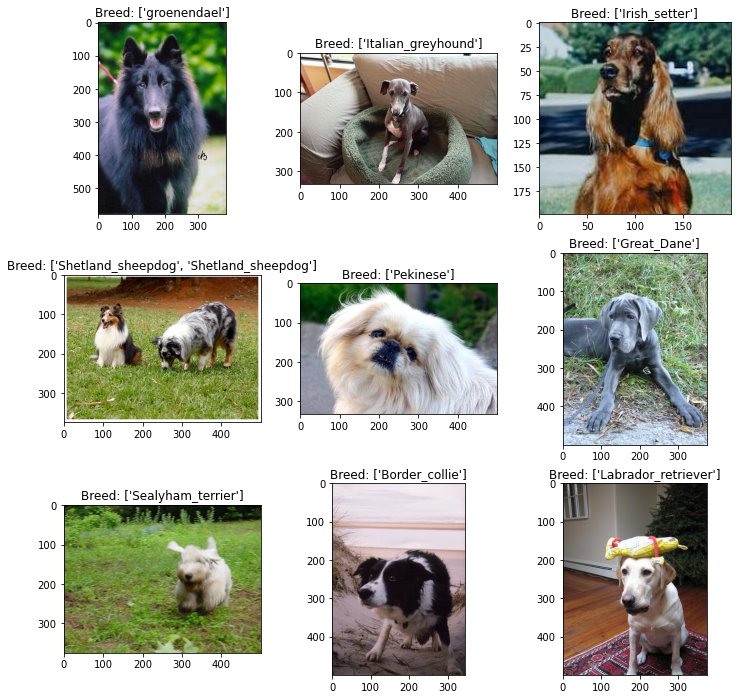

In [71]:
image_view(image_data_train, breed_names_train)